In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #-1~1

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=12)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71878265.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [4]:
trainset2 = iter(trainset)
images, labels = next(trainset2)
print(len(trainset), images.shape, labels)
print(trainset[0][0].shape)

50000 torch.Size([3, 32, 32]) 6
torch.Size([3, 32, 32])


print(len(trainloader))

for idx, data in enumerate(trainloader):
  print(data[1][0])
  data[1][0] = -111
  print(data[1][0])
  break
for idx, data in enumerate(trainloader):
  print(data[1])
  break
for images, labels in trainloader:
  print(len(trainloader), images.shape, labels)
  break
for images, labels in trainloader:
  pass
print(images.shape, labels.shape)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.name = "SimpleCNN"
        self.conv_layer = nn.Sequential(
            # nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3)),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3)),            
            nn.ReLU(inplace=True),
            # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # subsampling
            
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(32*5*5, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 10)
        )
     

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 32*5*5)
        x = self.fc_layer(x)
        return x

In [7]:
model = SimpleCNN()
model = model.to(device)
torchsummary.summary(model, input_size=(3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
              ReLU-2            [-1, 8, 30, 30]               0
            Conv2d-3           [-1, 16, 28, 28]           1,168
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           4,640
              ReLU-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           9,248
              ReLU-9           [-1, 32, 10, 10]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
          Dropout-11                  [-1, 800]               0
           Linear-12                   [-1, 64]          51,264
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def test_accuracy(model, testloader):
    correct = 0
    total = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        model.eval()
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = model(images)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [10]:
model.train()
for epoch in range(50):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;


        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        # one hot encoding
        inputs, labels = data

        inputs = inputs.to(device)
        labels = torch.Tensor(np.eye(10)[labels]).to(device)
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 30 == 29:
            # print(outputs.shape, labels.shape)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 30:.3f}')
            running_loss = 0.0
    test_accuracy(model, testloader)
print('Finished Training')

[1,    30] loss: 2.275
[1,    60] loss: 2.076
[1,    90] loss: 1.962
[1,   120] loss: 1.876
[1,   150] loss: 1.786
[1,   180] loss: 1.777
Accuracy of the network on the 10000 test images: 38 %
[2,    30] loss: 1.694
[2,    60] loss: 1.629
[2,    90] loss: 1.596
[2,   120] loss: 1.604
[2,   150] loss: 1.572
[2,   180] loss: 1.563
Accuracy of the network on the 10000 test images: 44 %
[3,    30] loss: 1.535
[3,    60] loss: 1.537
[3,    90] loss: 1.499
[3,   120] loss: 1.501
[3,   150] loss: 1.472
[3,   180] loss: 1.479
Accuracy of the network on the 10000 test images: 49 %
[4,    30] loss: 1.446
[4,    60] loss: 1.429
[4,    90] loss: 1.424
[4,   120] loss: 1.423
[4,   150] loss: 1.416
[4,   180] loss: 1.400
Accuracy of the network on the 10000 test images: 51 %
[5,    30] loss: 1.389
[5,    60] loss: 1.365
[5,    90] loss: 1.376
[5,   120] loss: 1.356
[5,   150] loss: 1.357
[5,   180] loss: 1.355
Accuracy of the network on the 10000 test images: 53 %
[6,    30] loss: 1.344
[6,    60] l

KeyboardInterrupt: ignored

In [11]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 66.0 %
Accuracy for class: car   is 86.6 %
Accuracy for class: bird  is 46.5 %
Accuracy for class: cat   is 41.9 %
Accuracy for class: deer  is 55.4 %
Accuracy for class: dog   is 53.9 %
Accuracy for class: frog  is 72.1 %
Accuracy for class: horse is 73.2 %
Accuracy for class: ship  is 80.8 %
Accuracy for class: truck is 76.9 %


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
    
    model.to('cpu')
    model.eval()
    y_pred = model(images)
    y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
    y = labels.detach().numpy()
    

In [14]:
def display_test(x, y, y_pred):
    plt_w = 10
    plt_h = int(np.round(x.shape[0] / plt_w))

    plt.figure(figsize=(18,18))

    for y_pos in range(plt_h):
        for x_pos in range(plt_w):
            idx = y_pos * plt_w + x_pos
            if idx >= x.shape[0] :
                break

            plt.subplot(plt_w, plt_h, idx+1)

            prt = '[%s, %s]' % (classes[y[idx]], classes[y_pred[idx]])
            plt.title(prt)
            plt.imshow(x[idx])

            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)

    plt.show()

In [15]:
images = images.numpy().transpose(0, 2, 3, 1) / 2 + 0.5 

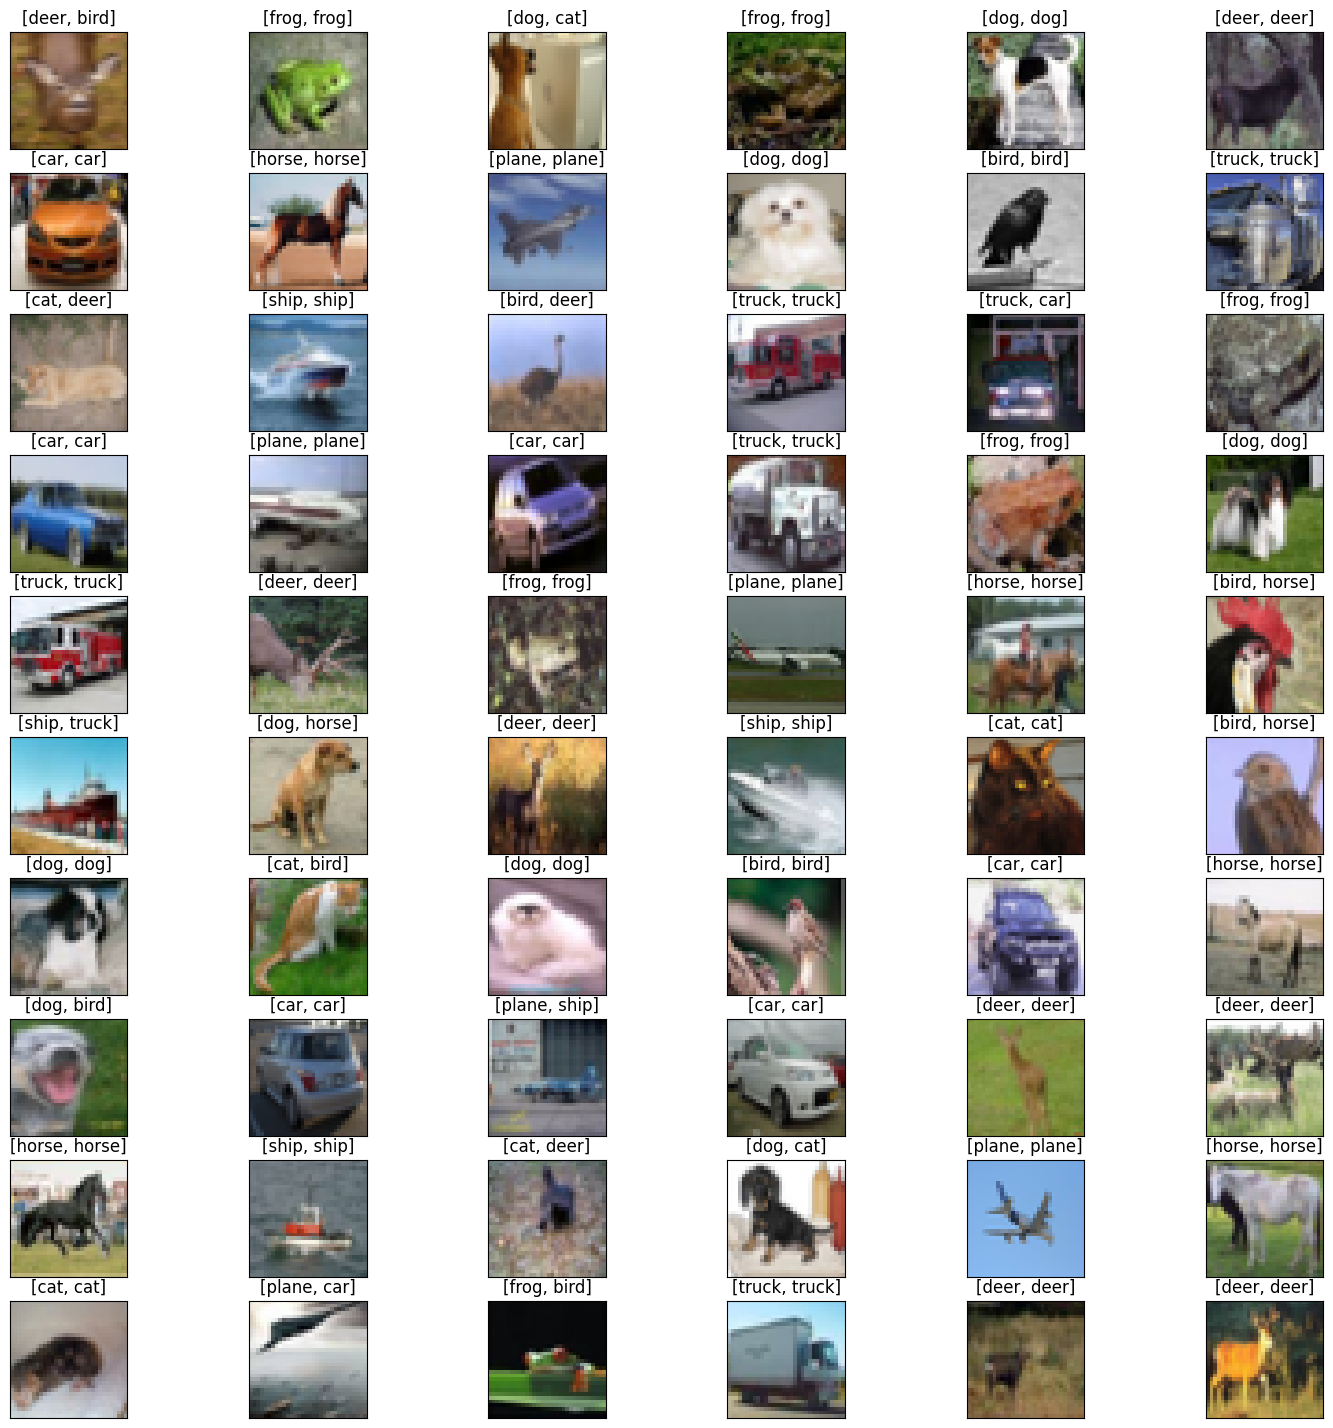

In [16]:
display_test(images[:60], y[:60], y_pred[:60])